In [1]:
import os
import sys
sys.path.append('../')
sys.path.append('../selections')
sys.path.append('../utils')
from os.path import join
import yaml
import uproot
import numpy as np
from matplotlib import pyplot as plt
from coffea import processor, util, hist
from coffea.lumi_tools import LumiMask
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
from processors.analysis_processor import AnalysisProcessor
from processors.fake_rate_processors import SS4lFakeRateProcessor
from utils.sample_utils import  *
from selections.weights import *
from pileup.pileup_utils import *
import warnings
warnings.filterwarnings('ignore')
    
# input files
source= 'data_UL'
group = ''
year = '2018'
is_UL = 'UL' in source
is_data = 'data' in source
sys.path.append("../")
indir = "../sample_lists/sample_yamls"
fileset = get_fileset(join(indir, f'data_UL_{year}.yaml'))

nevts_dict, dyjets_weights = None, None
if 'MC' in source or 'signal' in source: 
    nevts_dict = get_nevts_dict(fileset, year)

fileset = {key: val[0:1] for i, (key, val) in enumerate(fileset.items())}
           # if ('GluGluToA' in key) and ('225' in key)}

# load up golden jsons
golden_json_dir = '../sample_lists/data_certification'
golden_jsons = {'2018': join(golden_json_dir, 'data_cert_2018.json'),
                '2017': join(golden_json_dir, 'data_cert_2017.json'),
                '2016postVFP': join(golden_json_dir, 'data_cert_2016.json'),
                '2016preVFP': join(golden_json_dir, 'data_cert_2016.json')}
lumi_masks = {year: LumiMask(golden_json)
              for year, golden_json in golden_jsons.items()}
print(f'Using LumiMasks:\n{lumi_masks}')

# load up fake rates
fr_base = f'../corrections/fake_rates/UL_{year}'
fake_rates = get_fake_rates(fr_base, year)
#print(f'Using fake rates\n{fake_rates}')

# load up electron / muon IDs
eID_base = f'../corrections/electron_ID/UL_{year}'
eID_file = join(eID_base,
                f'Electron_RunUL{year}_IdIso_AZh_IsoLt0p15_IdFall17MVA90noIsov2.root')
eIDs = get_electron_ID_weights(eID_file)
print(f'Using eID_SFs:\n{eIDs}')

mID_base = f'../corrections/muon_ID/UL_{year}'
mID_file = join(mID_base,
                f'Muon_RunUL{year}_IdIso_AZh_IsoLt0p15_IdLoose.root')
mIDs = get_muon_ID_weights(mID_file)
print(f'Using mID_SFs:\n{mIDs}')

tID_base = f'../corrections/tau_ID/UL_{year}'
tID_file = join(tID_base, f'tau.corr.json')
tIDs = get_tau_ID_weights(tID_file)
print(f'Using tID_SFs:\n{tIDs}')

# load up electron / muon trigger SFs
e_trigs = {'2016preVFP': 'Ele25_EtaLt2p1', 
           '2016postVFP': 'Ele25_EtaLt2p1',
           '2017': 'Ele35', '2018': 'Ele35'}
e_trig_base = f'../corrections/electron_trigger/UL_{year}'
e_trig_file = join(e_trig_base, f'Electron_RunUL{year}_{e_trigs[year]}.root')
e_trig_SFs = get_electron_trigger_SFs(e_trig_file)

m_trigs = {'2016preVFP': 'IsoMu24orIsoTkMu24',
           '2016postVFP': 'IsoMu24orIsoTkMu24',
           '2017': 'IsoMu27', '2018': 'IsoMu27'}
m_trig_base = f'../corrections/muon_trigger/UL_{year}'
m_trig_file = join(m_trig_base, f'Muon_RunUL{year}_{m_trigs[year]}.root')
m_trig_SFs = get_muon_trigger_SFs(m_trig_file)


# load sample info
infile = f"../sample_lists/{source}_{year}.csv"
sample_info = load_sample_info(infile)

# get pileup tables
if not is_data:
    pileup_tables = get_pileup_tables(fileset.keys(), year, UL=True,
                                      pileup_dir='../pileup')
else:
    pileup_tables = False
    
dyjets_weights = None    
if group=='DY' or 'MC' in source:
    dyjets_weights = dyjets_stitch_weights(sample_info, nevts_dict, year)
    
else: dyjets_weights = None
print(f'Successfully built sum_of_weights dict:\n {nevts_dict}')
print(f'Successfully built dyjets stitch weights:\n {dyjets_weights}')

Using LumiMasks:
{'2018': <coffea.lumi_tools.lumi_tools.LumiMask object at 0x7ff5a4a77f70>, '2017': <coffea.lumi_tools.lumi_tools.LumiMask object at 0x7ff5a4372e20>, '2016postVFP': <coffea.lumi_tools.lumi_tools.LumiMask object at 0x7ff55c86b640>, '2016preVFP': <coffea.lumi_tools.lumi_tools.LumiMask object at 0x7ff5607d1190>}
Using eID_SFs:
{'Lt1p0': CustomWeights(), '1p0to1p48': CustomWeights(), '1p48to1p65': CustomWeights(), '1p65to2p1': CustomWeights(), 'Gt2p1': CustomWeights()}
Using mID_SFs:
{'Lt0p9': CustomWeights(), '0p9to1p2': CustomWeights(), '1p2to2p1': CustomWeights(), 'Gt2p1': CustomWeights()}
Using tID_SFs:
Successfully built sum_of_weights dict:
 None
Successfully built dyjets stitch weights:
 None


In [2]:
fake_rate = False
proc_instance = AnalysisProcessor(sample_info=sample_info,
                                  pileup_tables=pileup_tables,
                                  lumi_masks=lumi_masks,
                                  nevts_dict=nevts_dict,
                                  high_stats=True,
                                  eleID_SFs=eIDs, muID_SFs=mIDs, tauID_SFs=tIDs,
                                  fake_rates=fake_rates,
                                  dyjets_weights=dyjets_weights,
                                  e_trig_SFs=e_trig_SFs, m_trig_SFs=m_trig_SFs)

if fake_rate: 
    proc_instance = SS4lFakeRateProcessor(sample_info=sample_info,
                                          pileup_tables=pileup_tables,
                                          mode='tt',
                                          nevts_dict=nevts_dict,
                                          lumi_masks=lumi_masks,
                                          high_stats=True,
                                          eleID_SFs=eIDs,
                                          muID_SFs=mIDs,
                                          tauID_SFs=tIDs,
                                          dyjets_weights=dyjets_weights,
                                          e_trig_SFs=e_trig_SFs, m_trig_SFs=m_trig_SFs)
    
out = processor.run_uproot_job(
        fileset,
        treename="Events",
        processor_instance=proc_instance,
        executor=processor.futures_executor,
        executor_args={"schema": NanoAODSchema, 'workers': 1},
)

Preprocessing:   0%|          | 0/8 [00:00<?, ?file/s]

Processing:   0%|          | 0/17 [00:00<?, ?chunk/s]

...processing SingleMuon_Run2018D_2018

root://cmseos.fnal.gov//eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/SingleMuon_Run2018D/all_SingleMuon_Run2018D_file001_part_1of3_Muons.root
SingleMuon_Run2018D 1
...processing SingleMuon_Run2018D_2018

root://cmseos.fnal.gov//eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/SingleMuon_Run2018D/all_SingleMuon_Run2018D_file001_part_1of3_Muons.root
SingleMuon_Run2018D 1
...processing SingleMuon_Run2018D_2018

root://cmseos.fnal.gov//eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/SingleMuon_Run2018D/all_SingleMuon_Run2018D_file001_part_1of3_Muons.root
SingleMuon_Run2018D 1
...processing SingleMuon_Run2018C_2018

root://cmseos.fnal.gov//eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/SingleMuon_Run2018C/all_SingleMuon_Run2018C_file001_part_1of3_Muons.root
SingleMuon_Run2018C 1
...processing SingleMuon_Run2018C_2018

root://cmseos.fnal.gov//eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/Singl

['group', 'dataset', 'mass_type', 'category', 'bjets', 'sign', 'tauES_shift', 'eleES_shift', 'muES_shift', 'eleSmear_shift', 'mass']
(StrCategory(['data', 'reducible'], name='group', label='group'), StrCategory(['EGamma_Run2018A_2018', 'EGamma_Run2018B_2018', 'EGamma_Run2018C_2018', 'EGamma_Run2018D_2018', 'SingleMuon_Run2018A_2018', 'SingleMuon_Run2018B_2018', 'SingleMuon_Run2018C_2018', 'SingleMuon_Run2018D_2018'], name='dataset', label='dataset'), StrCategory(['cons', 'corr', 'raw'], name='mass_type', label='mass_type'), StrCategory(['eeem', 'eeet_fakes', 'eett_fakes', 'mmem', 'mmmt_fakes', 'mmtt', 'mmtt_fakes'], name='category', label='category'), StrCategory(['0 bjets', '>0 bjets'], name='bjets', label='bjets'), StrCategory(['OS', 'SS'], name='sign', label='sign'), StrCategory(['none'], name='tauES_shift', label='tauES_shift'), StrCategory(['none'], name='eleES_shift', label='eleES_shift'), StrCategory(['none'], name='muES_shift', label='muES_shift'), StrCategory(['none'], name='e

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


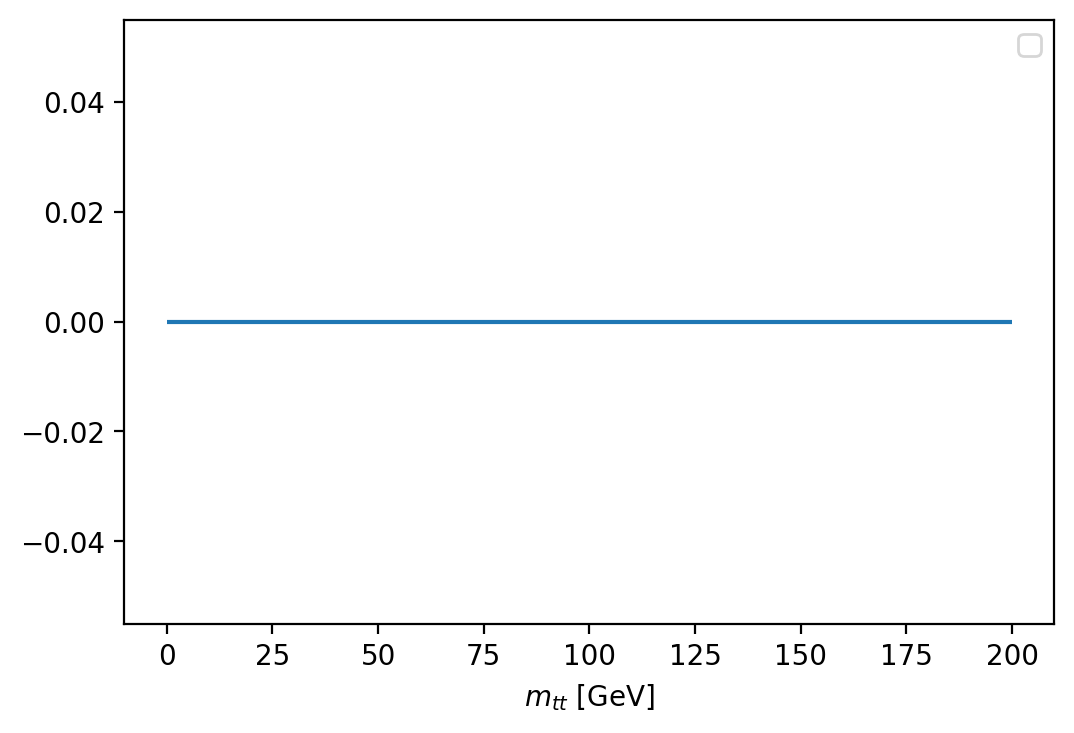

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=200)
print(out['mtt'].fields)
print(out['mtt'].to_hist().axes)
mll = out['mtt'].to_hist()[::sum, ::sum, 'raw', ::sum, ::sum, 'OS', 'nom', 'nom', 'down', 'nom', :]
mll.plot(ax=ax, histtype='step', overlay='muES_shift')
ax.legend(loc='best')

In [4]:
base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/DY4JetsToLLM-50'
file = join(base, 'all_DY4JetsToLLM-50_file001_part_1of3_Electrons.root')
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
ele = events.Electron
met = events.MET
mu = events.Muon

def apply_eleES(ele, met, syst='nom'):
    if (syst=='nom'): return ele, met
    flat_ele, num_ele = ak.flatten(ele), ak.num(ele)
    pt, eta = ele.pt, ele.eta
    phi, mass = ele.phi, ele.mass
    in_barrel = (abs(eta) < 1.479)
    in_crossover = ((abs(eta) > 1.479) & (abs(eta) < 1.653))
    in_endcap = (abs(eta) > 1.653)
    barrel_shifts = {'up': 1.03, 'down': 0.97}
    endcap_shifts = {'up': 1.05, 'down': 0.95}
    weights = (in_barrel * barrel_shifts[syst] +
               in_crossover * crossover_shifts[syst] +
               in_endcap * endcap_shifts[syst])
    ele_p4 = ak.zip({'pt': ele.pt, 'eta': ele.eta,
                     'phi': ele.phi, 'mass': ele.mass},
                     with_name='PtEtaPhiMLorentzVector')
    ele_p4_shift = (weights * ele_p4)
    ele['pt'] = ele_p4_shift.pt
    ele['eta'] = ele_p4_shift.eta
    ele['phi'] = ele_p4_shift.phi
    ele['mass'] = ele_p4_shift.mass
    ele_p4_diffs = ele_p4.add(ele_p4_shift.negative())
    ele_p4_diffs = ele_p4_diffs.sum(axis=1)
    met_p4 = ak.zip({'x': met.T1_pt * np.cos(met.T1_phi),
                     'y': met.T1_pt * np.sin(met.T1_phi),
                     'z': 0, 't': 0}, with_name='LorentzVector')
    met_p4 = met_p4.add(ele_p4_diffs)
    met['pt'] = met_p4.pt
    met['phi'] = met_p4.phi
    return ele, met

ele, met = apply_eleES(ele, met, syst='down')

def apply_muES(mu, met, syst='nom'):
    if (syst=='nom'): return mu, met
    flat_mu, num_mu = ak.flatten(mu), ak.num(mu)
    pt, eta = mu.pt, mu.eta
    phi, mass = mu.phi, mu.mass
    shifts = {'up': 1.01, 'down': 0.99}
    weights = shifts[syst]
    mu_p4 = ak.zip({'pt': mu.pt, 'eta': mu.eta,
                    'phi': mu.phi, 'mass': mu.mass},
                    with_name='PtEtaPhiMLorentzVector')
    mu_p4_shift = (weights * mu_p4)
    mu['pt'] = mu_p4_shift.pt
    mu['eta'] = mu_p4_shift.eta
    mu['phi'] = mu_p4_shift.phi
    mu['mass'] = mu_p4_shift.mass
    mu_p4_diffs = mu_p4.add(mu_p4_shift.negative())
    mu_p4_diffs = mu_p4_diffs.sum(axis=1)
    met_p4 = ak.zip({'x': met.T1_pt * np.cos(met.T1_phi),
                     'y': met.T1_pt * np.sin(met.T1_phi),
                     'z': 0, 't': 0}, with_name='LorentzVector')
    met_p4 = met_p4.add(mu_p4_diffs)
    met['pt'] = met_p4.pt
    met['phi'] = met_p4.phi
    return mu, met

mu, met = apply_muES(mu, met, syst='up')

NameError: name 'crossover_shifts' is not defined

In [ ]:
def apply_tau_ES(taus, met, SF_tool, syst='nom'):
    corr = SF_tool['tau_energy_scale']
    mask = (((taus.decayMode==0) | (taus.decayMode==1) |
             (taus.decayMode==2) | (taus.decayMode==10) |
             (taus.decayMode==11)) &
            (taus.genPartFlav < 6) &
            (taus.genPartFlav > 0))

    flat_taus, ntaus = ak.flatten(taus), ak.num(taus)
    flat_mask, nmask = ak.flatten(mask), ak.num(mask)
    pt = flat_taus.pt[flat_mask]
    eta = flat_taus.eta[flat_mask]
    dm = flat_taus.decayMode[flat_mask]
    genMatch = flat_taus.genPartFlav[flat_mask]
    ID = 'DeepTau2017v2p1'
    syst = syst

    TES = corr.evaluate(ak.to_numpy(pt), ak.to_numpy(eta), ak.to_numpy(dm), ak.to_numpy(genMatch), 'DeepTau2017v2p1', syst)
    TES_new = np.ones(len(flat_mask), dtype=float)
    TES_new[flat_mask] = TES
    TES = ak.unflatten(TES_new, ntaus)
    tau_p4 = ak.zip({'pt': taus.pt, 'eta': taus.eta,
                     'phi': taus.phi, 'mass': taus.mass},
                    with_name='PtEtaPhiMLorentzVector')
    taus['pt'] = taus.pt * TES
    taus['eta'] = taus.eta * TES
    taus['phi'] = taus.phi * TES
    taus['mass'] = taus.mass * TES
    tau_p4_corr = ak.zip({'pt': taus.pt, 'eta': taus.eta,
                          'phi': taus.phi, 'mass': taus.mass},
                         with_name='PtEtaPhiMLorentzVector')
    tau_p4_diff = tau_p4.add(tau_p4_corr.negative())
    tau_p4_diff = ak.sum(tau_p4_diff, axis=1)
    met_p4 = ak.zip({'x': met.T1_pt * np.cos(met.T1_phi),
                     'y': met.T1_pt * np.sin(met.T1_phi),
                     'z': 0, 't': 0},
                    with_name='LorentzVector')
    new_met = met_p4.add(tau_p4_diff)
    met['pt'] = new_met.pt
    met['phi'] = new_met.phi
    return taus, met

In [ ]:
file = fileset['GluGluToAToZhToLLTauTauM225_2018'][0]
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()

In [ ]:
from coffea.analysis_tools import Weights
weights = Weights(len(events.run), storeIndividual=True)
weights.add('genweight', events.genWeight)
weights.add('testweight', 3*ak.ones_like(events.run))
weights.add("L1Prefiring", events.L1PreFiringWeight.Nom, events.L1PreFiringWeight.Up, events.L1PreFiringWeight.Dn)
print(weights.weightStatistics)
print(weights.variations)
#print(weights.weight(modifier='L1PrefiringUp'))
pt = events.Muon.pt
print(pt[2])
pt = events.Muon.pt * np.array([1.0, 1.05, 0.95])[None, None, :]
print(pt[2])
events.Electron.dEsigmaDown


def apply_eleSmear(ele, met, syst='nom'):
    if (syst=='nom'): return ele, met
    shift = ele.dEsigmaUp if (syst=='up') else ele.dEsigmaDown
    weights = shift + 1.0
    ele_p4 = ak.zip({'pt': ele.pt, 'eta': ele.eta,
                     'phi': ele.phi, 'mass': ele.mass},
                    with_name='PtEtaPhiMLorentzVector')
    ele_p4_shift = (weights * ele_p4)
    ele['pt'] = ele_p4_shift.pt
    ele['eta'] = ele_p4_shift.eta
    ele['phi'] = ele_p4_shift.phi
    ele['mass'] = ele_p4_shift.mass
    ele_p4_diffs = ele_p4.add(ele_p4_shift.negative())
    ele_p4_diffs = ele_p4_diffs.sum(axis=1)
    met_p4 = ak.zip({'x': met.T1_pt * np.cos(met.T1_phi),
                     'y': met.T1_pt * np.sin(met.T1_phi),
                     'z': 0, 't': 0}, with_name='LorentzVector')
    print(met_p4)
    met_p4 = met_p4.add(ele_p4_diffs)
    met['pt'] = met_p4.pt
    met['phi'] = met_p4.phi
    return ele, met

ele = events.Electron
met = events.MET
print(met.pt)
ele, met = apply_eleSmear(ele, met, syst='up')
print(met.pt)

In [ ]:
events.add_systematic("XSectionUncertainty", "UpDownSystematic", "weight", some_event_weight)

In [ ]:
from selections.preselections import *
from utils.cutflow import Cutflow
from selections.weights import *
from coffea import analysis_tools 

cutflow = Cutflow()

e = events
baseline_e = get_baseline_electrons(e.Electron, cutflow)
baseline_m = get_baseline_muons(e.Muon, cutflow)
baseline_t = get_baseline_taus(e.Tau, cutflow, is_UL=is_UL)
baseline_j = get_baseline_jets(e.Jet, cutflow)
baseline_b = get_baseline_bjets(baseline_j, cutflow)
b_counts = ak.num(baseline_b)
MET = e.MET
if not is_data:
    baseline_t, MET = apply_tau_ES(baseline_t, MET,
                                   tIDs, syst='nom')

# seeds the lepton count veto
e_counts = ak.num(baseline_e[tight_electrons(baseline_e)])
m_counts = ak.num(baseline_m[tight_muons(baseline_m)])

ll_pairs, ll_weights = {}, {}
weights = analysis_tools.Weights(len(events), storeIndividual=True)
for cat in ['ee', 'mm']:
    if is_data and (cat[:2]=='ee') and ('EGamma' not in dataset): continue
    if is_data and (cat[:2]=='mm') and ('SingleMuon' not in dataset): continue
    mask = check_trigger_path(events.HLT, year, cat, cutflow)
    l = baseline_e if (cat=='ee') else baseline_m
    ll = ak.combinations(l, 2, axis=1, fields=['l1', 'l2'])
    ll = dR_ll(ll, cutflow)
    ll = build_Z_cand(ll, cutflow)
    ll = closest_to_Z_mass(ll)
    mask, tpt1, teta1, tpt2, teta2 = trigger_filter(ll,
                                                    events.TrigObj,
                                                    cat, cutflow)
    ll = ak.fill_none(ll.mask[mask], [], axis=0)
    ll_pairs[cat] = ll
    
    trig_SFs = e_trig_SFs if cat[0]=='e' else m_trig_SFs
    if not is_data:
        weight = np.ones(len(events), dtype=float)
        wt1 = lepton_trig_weight(weight, tpt1, teta1, trig_SFs, lep=cat[0])
        wt2 = lepton_trig_weight(weight, tpt2, teta2, trig_SFs, lep=cat[0])
        weights.add('l1_trig_weight', wt1)
        weights.add('l2_trig_weight', wt2)

candidates, cat_weights, fake_candidates = {}, {}, {}
for cat in ['eemt', 'eeet', 'eeem', 'eett', 'mmmt', 'mmet', 'mmem', 'mmtt']:
    # build di-tau candidate
    if cat[2:]=='mt':
        tt = ak.cartesian({'t1': baseline_m, 't2': baseline_t}, axis=1)
    elif cat[2:]=='et':
        tt = ak.cartesian({'t1': baseline_e, 't2': baseline_t}, axis=1)
    elif cat[2:]=='em':
        tt = ak.cartesian({'t1': baseline_e, 't2': baseline_m}, axis=1)
    elif cat[2:]=='tt':
        tt = ak.combinations(baseline_t, 2, axis=1, fields=['t1', 't2'])

    # build 4l final state
    lltt = ak.cartesian({'ll': ll_pairs[cat[:2]], 'tt': tt}, axis=1)
    lltt = lltt[~ak.is_none(lltt, axis=1)]
    lltt = dR_lltt(lltt, cat, cutflow)
    lltt = build_ditau_cand(lltt, cat, cutflow, OS=True)
    lltt = highest_LT(lltt, cutflow)
    tight_masks = get_tight_masks(lltt, cat)
    l1_tight_mask, l2_tight_mask = tight_masks[0], tight_masks[1]
    t1_tight_mask, t2_tight_mask = tight_masks[2], tight_masks[3]
    tight_mask = (l1_tight_mask & l2_tight_mask &
                  t1_tight_mask & t2_tight_mask)
    
    # apply fake weights to estimate reducible background
    if is_data:
        fw1, fw2, fw3, fw4 = self.get_fake_weights(lltt, cat,
                                                   tight_masks)
        fake_weights = fw1*fw2*fw3*fw4
        weights.add('fake_weights', fake_weights)
        fakes, cands = lltt[~tight_mask], lltt[tight_mask] 
        fake_candidates[cat] = fakes
        candidates[cat] = cands
    
    if not is_data:
        prompt_mask = is_prompt(lltt, cat)
        cands = lltt[prompt_mask & tight_mask]
        #weights.add('lepton_ID_SFs',
        #            self.apply_lepton_ID_SFs(lltt, cat))
        candidates[cat] = cands

candidate_counts = [ak.num(lltt) for lltt in candidates.values()]
counts_mask = (ak.sum(candidate_counts, axis=0)==1)

# fill the good candidates
for cat, cands in candidates.items():
    mask = counts_mask & (ak.num(lltt, axis=1)>0)
    for k, bjet_label in enumerate(['0 bjets', '>0 bjets']):
        bjet_mask = (b_counts==0) if (k==0) else (b_counts>0)
        final_mask = mask & bjet_mask
        print(len(lltt))
        lltt = lltt[final_mask]
        met = events.MET[final_mask]
        weight = weights.weight()[final_mask]


In [ ]:
out['mll'].values()
mll = out['mll']
print(mll.fields)
mll = mll[:,:,:,:,:]
print(mll.axis('group').identifiers())
for f in mll.fields:
    if (f=='mll') or (f=='group'): continue
    mll = mll.sum(f)
hist.plot1d(mll, overlay='group')

In [ ]:
from coffea import hist
import mplhep as hep
#hep.style.use(hep.style.ROOT) # For now ROOTdefaults to CMS
hep.style.use(["CMS", "fira", "firamath"])

def cms_plot(h, overlay):
    fig = plt.figure(figsize=(12,12))
    hep.cms.label('Preliminary', data=False, lumi=59.7, year=2018)
    ax = hist.plot1d(h, overlay=overlay, overflow='none')
    #ax.get_legend().remove()
    plt.tight_layout()
    plt.show()
    plt.clf()
    
legend_opts = {}
mass = out['mT']
print(mass.fields)
mass = mass[:, :, :, :, 'numerator', :, :, :]
for f in mass.fields:
    if (f=='mT') or (f=='prompt'): continue
    mass = mass.sum(f)
print(mass.fields)
cms_plot(mass, 'prompt')
#hist.plot1d(cons_mass, ax=axs[2], overlay='dataset')

In [ ]:
legend_opts = {}
pt = out['mT']
print(pt.values())
print(pt.fields)
pt = pt[:, :, :, :, 'e', 'denominator', :, :, :]
#mass = mass.sum('dataset', overflow='none')
pt = pt.sum('group', overflow='none')
pt = pt.sum('dataset', overflow='none')
pt = pt.sum('category', overflow='none')
pt = pt.sum('numerator', overflow='none')
pt = pt.sum('mode', overflow='none')
pt = pt.sum('pt_bin', overflow='none')
pt = pt.sum('eta_bin', overflow='none')
print(pt.fields)

cms_plot(pt, 'prompt')

In [ ]:
base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/'
print([f for f in os.listdir(base) if 'ZZTo' in f])
sample = join(base, 'GluGluToContinToZZTo2mu2tau')
files = os.listdir(sample)
for f in files:
    print(f, len(uproot.open(join(sample, f))['Events;1'].arrays().Tau_genPartFlav))

In [ ]:
import awkward as ak
# ls /eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/GluGluToAToZhToLLTauTauM1400
base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/'
file = join(base, 'DYJetsToLLM-50/all_DYJetsToLLM-50_file012_part_1of3_Electrons.root')
#file = 'root://cmseos.fnal.gov//eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/TTToHadronic/all_TTToHadronic_file001_part_2of3_Muons.root'
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
#print([f for f in events.Muon.fields if 'Id' in f])

print(ak.flatten(events.Electron.dEscaleDown[events.Electron.dEscaleDown<0]))
print(events.Electron.fields)

In [ ]:
tau = ak.unflatten(events.Tau[:,0], np.ones(len(events.Tau), dtype=int))
prod = ak.cartesian({'tau': tau, 'gen': events.GenPart}, axis=1)
dR = prod['tau'].delta_r(prod['gen'])
prod = prod[dR<0.2]
dR = prod['tau'].delta_r(prod['gen'])
t, m = prod['tau'], prod['gen']


prod = prod[ak.argmin(dR, axis=1, keepdims=True, mask_identity=False)]

def match_leptonic_taus(gen, tau, lep='e'):
    pdgId = 11 if lep=='e' else 13
    prompt = 1 if lep=='e' else 2
    tau_decay = 3 if lep=='e' else 4
    return ((abs(gen.pdgId)==pdgId) &
            (gen.pt>8) & 
            (((tau.genPartFlav==prompt) &
              (gen.hasFlags('isPrompt'))
             ) | 
             ((tau.genPartFlav==tau_decay) &
              (gen.hasFlags('isDirectPromptTauDecayProduct'))
             )))

def match_hadronic_taus(gen, tau):
    return ((gen.pt>15) & 
            (tau.genPartFlav==5))

mu_match = match_leptonic_taus(prod['gen'], prod['tau'], 'm')
e_match = match_leptonic_taus(prod['gen'], prod['tau'], 'e')
tau_match = match_hadronic_taus(prod['gen'], prod['tau'])

t, match = prod['tau'], prod['gen']
np.unique(ak.flatten(match.pdgId))

In [ ]:
base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/'
file = join(base, 'all_GluGluToAToZhToLLTauTauM1000_file001_part_1of3_Electrons.root')
os.listdir(base)

In [ ]:
from cutflow import Cutflow
from coffea import analysis_tools
from preselections import *

cutflow = Cutflow()
global_selections = analysis_tools.PackedSelection()
filter_MET(events, global_selections, cutflow, year,
           UL=is_UL, data=is_data)
filter_PV(events, global_selections, cutflow)
global_mask = global_selections.all(*global_selections.names)
events = events[global_mask]

weights = analysis_tools.Weights(len(events))
ones = np.ones(len(events))
weights.add('sample_weight', ones*1)

# grab baselinely defined leptons
baseline_e = get_baseline_electrons(events.Electron, cutflow)
baseline_m = get_baseline_muons(events.Muon, cutflow)
baseline_t = get_baseline_taus(events.Tau, cutflow, is_UL=is_UL)
baseline_j = get_baseline_jets(events.Jet, cutflow)
baseline_b = get_baseline_bjets(baseline_j, cutflow)

# count the number of leptons per event
e_counts = ak.num(baseline_e)
m_counts = ak.num(baseline_m)
b_counts = ak.num(baseline_b)

In [ ]:
categories = {1: 'eeet', 2: 'eemt', 3: 'eett', 4: 'eeem',
              5: 'mmet', 6: 'mmmt', 7: 'mmtt', 8: 'mmem'}

for num, cat in categories.items():
    print(cat)

    # event-level masks
    mask = check_trigger_path(events.HLT, year, cat, cutflow)
    mask = mask & lepton_count_veto(e_counts, m_counts,
                                    cat, cutflow)
    #mask = mask & bjet_veto(baseline_b, self.cutflow)

    # build Zll candidate, check trigger filter
    if (cat[:2]=='ee'):
        ll = ak.combinations(baseline_e, 2, axis=1,
                             fields=['l1', 'l2'])
    elif (cat[:2]=='mm'):
        ll = ak.combinations(baseline_m, 2, axis=1,
                             fields=['l1', 'l2'])
    ll = dR_ll(ll, cutflow)
    ll = build_Z_cand(ll, cutflow)
    mask = mask & trigger_filter(ll, events.TrigObj,
                                 cat, cutflow)
    
    # build di-tau candidate
    if cat[2:]=='mt':
        tt = ak.cartesian({'t1': baseline_m, 't2': baseline_t}, axis=1)
    elif cat[2:]=='et':
        tt = ak.cartesian({'t1': baseline_e, 't2': baseline_t}, axis=1)
    elif cat[2:]=='em':
        tt = ak.cartesian({'t1': baseline_e, 't2': baseline_m}, axis=1)
    elif cat[2:]=='tt':
        tt = ak.combinations(baseline_t, 2, axis=1, fields=['t1', 't2'])

    # build 4l final state
    lltt = ak.cartesian({'ll': ll, 'tt': tt}, axis=1)
    lltt = dR_lltt(lltt, cat, cutflow)
    lltt = build_ditau_cand(lltt, cat, cutflow)
    mask = mask & (ak.num(lltt, axis=1) > 0)
    lltt = lltt[mask]
    met = events.MET[mask]
    w = weights.weight()[mask]
    print(weights.weight()[mask])
    
    # tighter selections
    mask = higgsLT(lltt, cat, cutflow)
    mask = mask & iso_ID(lltt, cat, cutflow)
    lltt = lltt[mask]
    print(ak.sum(ak.num(lltt, axis=1)))

In [ ]:
from coffea.lumi_tools import LumiMask
lumi_mask = LumiMask('../sample_lists/data_certification/data_cert_2018.json')
lumi_mask = lumi_mask(events.run, events.luminosityBlock)


In [ ]:
f = uproot.open(file)
f.keys()

In [ ]:
base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/DY4JetsToLLM-50'
file = join(base, 'all_DY4JetsToLLM-50_file001_part_1of3_Electrons.root')
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()

In [ ]:
ID = events.Tau.idDeepTau2017v2p1VSjet[0:6]
print(ID)
print(ID & 1)
a, b = 15, 16
print('ID:', a)
print(2**0 + 2**1 + 2**2 + 2**3 + 2**4 + 2**5)
print(bin(a))
print(bin(b))
print(bin(a & b))
print(a & b)

In [ ]:
class CustomWeights:
    def __init__(self, bins, weights):
        self.bins = bins
        self.weights = weights
        self.max_bin = np.argmax(bins)
        self.min_bin = np.argmin(bins)

    def apply(self, array):
        bin_idx = np.digitize(array, self.bins) - 1
        bin_idx[bin_idx<self.min_bin] = self.min_bin
        bin_idx[bin_idx>self.max_bin] = self.max_bin
        return self.weights[bin_idx]

    def __call__(self, array):
        return self.apply(array)

    def __repr__(self):
        return('CustomWeights()')

    def __str__(self):
        out = f'CustomWeights()\n - bins: {self.bins}\n - weights: {self.weights}'
        return out

def dyjets_stitch_weights(info, nevts_dict, year):
    lumis = {'2016preVFP': 35.9*1000, '2016postVFP': 35.9*1000,
             '2017': 41.5*1000, '2018': 59.7*1000}
    lumi = lumis[year]
    # sort the nevts and xsec by the number of jets 
    dyjets = info[info['group']=='DY']
    nevts = {'inc': 0, '1': 0, '2': 0, '3': 0, '4': 0}
    xsec = {'inc': 0, '1': 0, '2': 0, '3': 0, '4': 0}
    weights = {}
    for sample in dyjets:
        sample_name = sample['name'] + f'_{year}'
        njets = sample['name'][2]
        if njets.isnumeric():
            nevts[njets] += nevts_dict[sample_name]
            xsec[njets] = sample['xsec']
        else:
            nevts['inc'] += nevts_dict[sample_name]
            xsec['inc'] = sample['xsec']
    
    print(xsec)
    p_inc = nevts['inc']/xsec['inc']
    w_1jet = lumi * (p_inc + nevts['1']/xsec['1'])**-1
    w_2jet = lumi * (p_inc + nevts['2']/xsec['2'])**-1
    w_3jet = lumi * (p_inc + nevts['3']/xsec['3'])**-1
    w_4jet = lumi * (p_inc + nevts['4']/xsec['4'])**-1
    p1, p2 = xsec['1']/xsec['inc'], xsec['2']/xsec['inc']
    p3, p4 = xsec['3']/xsec['inc'], xsec['4']/xsec['inc']
    N_0jet = nevts['inc'] * (1 - p1 - p2 - p3 - p4)
    #w_0jet = lumi * xsec['inc'] / N_0jet
    w_0jet = lumi * xsec['inc'] / nevts['inc']
    bins = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
    weights = np.array([w_0jet, w_1jet, w_2jet, w_3jet, 
                        w_4jet, w_0jet])
    return CustomWeights(bins, weights)

njets = ak.to_numpy(events.LHE.Njets)
w = dyjets_stitch_weights(sample_info, nevts_dict, '2018')
print(w)
w(njets)/(1000*59/10**6)

In [ ]:
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)


import awkward as ak
import numpy as np

base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/DY4JetsToLLM-50'
file = join(base, 'all_DY4JetsToLLM-50_file001_part_1of3_Electrons.root')
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()

tID_base = f'../corrections/tau_ID/UL_{year}'
tID_file = join(tID_base, f'tau.corr.json')
tIDs = get_tau_ID_weights(tID_file)
print([f for f in events.fields if 'MET' in f])
print(events['PuppiMET'][1])
print(events.MET.fields)

In [ ]:
corr = tIDs['tau_energy_scale']
taus = events.Tau
met = events.MET

#taus = ak.flatten(taus[ak.argmax(taus.pt, keepdims=True, axis=1)])
mask = (((taus.decayMode==0) | (taus.decayMode==1) |
         (taus.decayMode==2) | (taus.decayMode==10) | 
         (taus.decayMode==11)) &
         (taus.genPartFlav < 6) & 
         (taus.genPartFlav > 0))

#taus = taus[mask]
#taus = taus[~ak.is_none(taus, axis=0)]
#met = met[~ak.is_none(taus, axis=0)]

flat_taus, ntaus = ak.flatten(taus), ak.num(taus)
flat_mask, nmask = ak.flatten(mask), ak.num(mask)
pt = flat_taus.pt[flat_mask]
eta = flat_taus.eta[flat_mask]
dm = flat_taus.decayMode[flat_mask]
genMatch = flat_taus.genPartFlav[flat_mask]
ID = 'DeepTau2017v2p1'
syst = 'nom'

TES = corr.evaluate(ak.to_numpy(pt), ak.to_numpy(eta), ak.to_numpy(dm), ak.to_numpy(genMatch),
                    'DeepTau2017v2p1', 'nom')
TES_new = np.ones(len(flat_mask), dtype=float)
TES_new[flat_mask] = TES
TES = ak.unflatten(TES_new, ntaus)
print(TES[taus.genPartFlav!=5])

tau_p4 = ak.zip({'pt': taus.pt, 'eta': taus.eta,
                'phi': taus.phi, 'mass': taus.mass},
               with_name='PtEtaPhiMLorentzVector')

taus['pt'] = taus.pt * TES
taus['eta'] = taus.eta * TES
taus['phi'] = taus.phi * TES
taus['mass'] = taus.mass * TES
tau_p4_corr = ak.zip({'pt': taus.pt, 'eta': taus.eta,
                      'phi': taus.phi, 'mass': taus.mass},
                     with_name='PtEtaPhiMLorentzVector')

tau_p4_diff = tau_p4.add(tau_p4_corr.negative())
tau_p4_diff = ak.sum(tau_p4_diff, axis=1)

met_p4 = ak.zip({'x': met.T1_pt * np.cos(met.T1_phi), 
                 'y': met.T1_pt * np.sin(met.T1_phi),
                 'z': 0, 't': 0},
                with_name='LorentzVector')
new_met = met_p4.add(tau_p4_diff)
print(new_met.pt)
met['pt'] = new_met.pt
met['phi'] = new_met.phi
plt.hist(met.pt, label='corrected')
plt.hist(met.T1_pt, label='initial')
plt.show()

In [ ]:
corr = tIDs['tau_energy_scale']
taus = events.Tau
met = events.MET
#taus = ak.flatten(taus[ak.argmax(taus.pt, keepdims=True, axis=1)])
mask = (((taus.decayMode==0) | (taus.decayMode==1) |
         (taus.decayMode==2) | (taus.decayMode==10) | 
         (taus.decayMode==11)) &
         (taus.genPartFlav < 6) & 
         (taus.genPartFlav > 0))

#taus = taus[mask]
#taus = taus[~ak.is_none(taus, axis=0)]
#met = met[~ak.is_none(taus, axis=0)]

flat_taus, ntaus = ak.flatten(taus), ak.num(taus)
flat_mask, nmask = ak.flatten(mask), ak.num(mask)
pt = flat_taus.pt[flat_mask]
eta = flat_taus.eta[flat_mask]
dm = flat_taus.decayMode[flat_mask]
genMatch = flat_taus.genPartFlav[flat_mask]
ID = 'DeepTau2017v2p1'
syst = 'nom'
#tau_ES = corr.evaluate(pt, eta, dm, genMatch, ID, syst)
#print(corr(pt, eta, dm, genMatch))

TES = corr.evaluate(ak.to_numpy(pt), ak.to_numpy(eta), ak.to_numpy(dm), ak.to_numpy(genMatch),
                    'DeepTau2017v2p1', 'nom')
TES_new = np.ones(len(flat_mask), dtype=float)
TES_new[flat_mask] = TES
TES = ak.unflatten(TES_new, ntaus)

tau_p4 = ak.zip({'pt': taus.pt, 'eta': taus.eta,
                'phi': taus.phi, 'mass': taus.mass},
               with_name='PtEtaPhiMLorentzVector')
print(ak.type(tau_p4))
taus['pt'] = taus.pt * TES
taus['eta'] = taus.eta * TES
taus['phi'] = taus.phi * TES
taus['mass'] = taus.mass * TES
tau_p4_corr = ak.zip({'pt': taus.pt, 'eta': taus.eta,
                      'phi': taus.phi, 'mass': taus.mass},
                     with_name='PtEtaPhiMLorentzVector')
print(ak.type(tau_p4_corr))
tau_p4_diff = tau_p4.add(tau_p4_corr.negative())
tau_p4_diff = ak.sum(tau_p4_diff, axis=1)

print(tau_p4_diff.fields)
print(met.pt)
met_p4 = ak.zip({'x': met.T1_pt * np.cos(met.T1_phi), 
                 'y': met.T1_pt * np.sin(met.T1_phi),
                 'z': 0, 't': 0},
                with_name='LorentzVector')

new_met = met_p4.add(tau_p4_diff)


In [ ]:
f = uproot.open(file)
f.keys()
f['Events'].keys()

In [ ]:
year = '2018'
indir = '../corrections/electron_trigger/'
print(os.listdir('../corrections/muon_trigger/UL_2018'))
indir = join(indir, f'UL_{year}')
e_trigger_SFs = join(indir, 'Electron_RunUL2018_Ele35.root')
e_trigger_SFs = uproot.open(e_trigger_SFs)
e_trigger_SFs.keys()

eta_map = {'Lt1p0': 0, '1p0to1p48': 0, '1p48to1p65': 0, 
           '1p65to2p1': 0, 'Gt2p1': 0}
for eta_range in eta_map.keys():
    mc_bins, mc_counts = e_trigger_SFs[f'ZMassEta{eta_range}_MC;1'].values()
    data_bins, data_counts = e_trigger_SFs[f'ZMassEta{eta_range}_Data;1'].values()
    ratio = np.nan_to_num(data_counts/mc_counts, 0, posinf=0, neginf=0)
    weights = CustomWeights(data_bins, ratio)
    eta_map[eta_range] = weights
    
    #fig, (ax, rax) = plt.subplots(
    #nrows=2,
    #ncols=1,
    #figsize=(7,7),
    #gridspec_kw={"height_ratios": (3, 1)},
    #sharex=True)
    #fig.subplots_adjust(hspace=.07)

    #ax.plot(mc_bins, mc_counts, 'b.', label='MC')
    #ax.plot(data_bins, data_counts, 'k.', label='data')
    #rax.plot(data_bins, ratio, 'k.')
    #plt.legend(loc='best')
    #rax.set_ylim([-0.5, 1.5])
    
print(eta_map)

In [ ]:
year = '2018'
indir = '../corrections/muon_trigger/'
indir = join(indir, f'UL_{year}')
print(os.listdir('../corrections/muon_trigger/UL_2018'))
m_trigger_SFs = join(indir, 'Muon_RunUL2018_IsoMu27.root')
m_trigger_SFs = uproot.open(m_trigger_SFs)
print(e_trigger_SFs.keys())

eta_map = {'Lt0p9': 0, '0p9to1p2': 0, '1p2to2p1': 0, 'Gt2p1': 0}
for eta_range in eta_map.keys():
    mc_bins, mc_counts = e_trigger_SFs[f'ZMassEta{eta_range}_MC;1'].values()
    data_bins, data_counts = e_trigger_SFs[f'ZMassEta{eta_range}_Data;1'].values()
    ratio = np.nan_to_num(data_counts/mc_counts, 0, posinf=0, neginf=0)
    weights = CustomWeights(data_bins, ratio)
    eta_map[eta_range] = weights
    
    #fig, (ax, rax) = plt.subplots(
    #    nrows=2, ncols=1, figsize=(7,7),
    #    gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    #fig.subplots_adjust(hspace=.07)

    #ax.plot(mc_bins, mc_counts, 'b.', label='MC')
    #ax.plot(data_bins, data_counts, 'k.', label='data')
    #rax.plot(data_bins, ratio, 'k.')
    #plt.legend(loc='best')
    #rax.set_ylim([-0.5, 1.5])
    
print(eta_map)

In [ ]:
def get_electron_trigger_SFs(infile):
    trigger_SFs = uproot.open(infile)
    eta_map = {'Lt1p0': 0, '1p0to1p48': 0, '1p48to1p65': 0,
               '1p65to2p1': 0, 'Gt2p1': 0}
    for eta_range in eta_map.keys():
        mc_bins, mc_counts = trigger_SFs[f'ZMassEta{eta_range}_MC;1'].values()
        data_bins, data_counts = trigger_SFs[f'ZMassEta{eta_range}_Data;1'].values()
        ratio = np.nan_to_num(data_counts/mc_counts, 0, posinf=0, neginf=0)
        weights = CustomWeights(data_bins, ratio)
        eta_map[eta_range] = weights
    return eta_map

def get_muon_trigger_SFs(infile):
    trigger_SFs = uproot.open(infile)
    eta_map = {'Lt0p9': 0, '0p9to1p2': 0, '1p2to2p1': 0, 'Gt2p1': 0}
    for eta_range in eta_map.keys():
        mc_bins, mc_counts = trigger_SFs[f'ZMassEta{eta_range}_MC;1'].values()
        data_bins, data_counts = trigger_SFs[f'ZMassEta{eta_range}_Data;1'].values()
        ratio = np.nan_to_num(data_counts/mc_counts, 0, posinf=0, neginf=0)
        weights = CustomWeights(data_bins, ratio)
        eta_map[eta_range] = weights
    return eta_map

indir = '../corrections/electron_trigger/'
indir = join(indir, f'UL_{year}')
e_trigger_SFs = join(indir, 'Electron_RunUL2018_Ele35.root')
print(get_electron_trigger_SFs(e_trigger_SFs))

year = '2018'
indir = '../corrections/muon_trigger/'
indir = join(indir, f'UL_{year}')
m_trigger_SFs = join(indir, 'Muon_RunUL2018_IsoMu27.root')
get_muon_trigger_SFs(m_trigger_SFs)

In [ ]:
def get_electron_ID_weights(infile):
    f = uproot.open(infile)
    print(f.keys())
    eta_map = {'Lt1p0': 0, '1p0to1p48': 0, '1p48to1p65': 0,
               '1p65to2p1': 0, 'Gt2p1': 0}    
    for eta_range in eta_map.keys():
        mc_bins, mc_counts = f[f'ZMassEta{eta_range}_MC;1'].values()
        data_bins, data_counts = f[f'ZMassEta{eta_range}_Data;1'].values()
        ratio = np.nan_to_num(data_counts/mc_counts, 0, posinf=0, neginf=0)
        weights = CustomWeights(data_bins, ratio)
        eta_map[eta_range] = weights
    return eta_map

get_electron_ID_weights('../corrections/electron_ID/UL_2018/Electron_RunUL2018_IdIso_AZh_IsoLt0p15_IdFall17MVA90noIsov2.root')
os.listdir('../corrections/electron_ID/UL_2018')

In [ ]:
def get_muon_ID_weights(infile):
    f = uproot.open(infile)
    eta_map = {'Lt0p9': 0, '0p9to1p2': 0, '1p2to2p1': 0, 'Gt2p1': 0}
    for eta_range in eta_map.keys():
        mc_bins, mc_counts = f[f'ZMassEta{eta_range}_MC;1'].values()
        data_bins, data_counts = f[f'ZMassEta{eta_range}_Data;1'].values()
        ratio = np.nan_to_num(data_counts/mc_counts, 0, posinf=0, neginf=0)
        weights = CustomWeights(data_bins, ratio)
        eta_map[eta_range] = weights
    return eta_map

print(os.listdir('../corrections/muon_ID/UL_2018'))
get_muon_ID_weights('../corrections/muon_ID/UL_2018/Muon_RunUL2018_IdIso_AZh_IsoLt0p15_IdLoose.root')

In [ ]:
def lepton_ID_weight(l, lep, SF_tool, is_data=False):
    eta_map = {'e': {'Lt1p0': [0, 1], '1p0to1p48': [1, 1.48],
                     '1p48to1p65': [1.48, 1.65], '1p65to2p1': [1.65, 2.1],
                     'Gt2p1': [2.1, 100]},
               'm': {'Lt0p9': [0, 0.9], '0p9to1p2': [0.9, 1.2],
                     '1p2to2p1': [1.2, 2.1], 'Gt2p1': [2.1, 100]}}
    eta_map = eta_map[lep]
    eta = ak.to_numpy(abs(ak.flatten(l.eta)))
    pt = ak.to_numpy(ak.flatten(l.pt))
    weight = np.zeros(len(l), dtype=float)
    for key, eta_range in eta_map.items():
        mask = ((eta > eta_range[0]) &
                (eta <= eta_range[1]))
        if len(mask)==0: continue
        weight += (SF_tool[key](pt)*mask)
    return weight

lep = events.Muon
lep = lep[ak.num(lep, axis=1)>0][:,0]
m = get_muon_ID_weights('../corrections/muon_ID/UL_2018/Muon_RunUL2018_IdIso_AZh_IsoLt0p15_IdLoose.root')
lepton_ID_weight(lep, 'm', m)

In [ ]:
from selections.preselections import *

def trigger_filter(ll, trig_obj, cat, cutflow):
    if cat[:2] == 'ee': pt_min = 36
    if cat[:2] == 'mm': pt_min = 28

    lltrig = ak.cartesian({'ll': ll, 'trobj': trig_obj}, axis=1)
    l1dR_matches = (lltrig['ll']['l1'].delta_r(lltrig['trobj']) < 0.5)
    l2dR_matches = (lltrig['ll']['l2'].delta_r(lltrig['trobj']) < 0.5)
    filter_bit = ((lltrig['trobj'].filterBits & 2) > 0)
    if cat[:2] == 'mm': filter_bit = (filter_bit |
                                      (lltrig['trobj'].filterBits & 8 > 0))

    l1_matches = lltrig[l1dR_matches &
                        (lltrig['ll']['l1'].pt > pt_min) &
                        filter_bit]
    l1_match_counts = ak.sum(~ak.is_none(l1_matches, axis=1), axis=1)
    l2_matches = lltrig[l2dR_matches &
                        (lltrig['ll']['l2'].pt > pt_min) &
                        filter_bit]
    l2_match_counts = ak.sum(~ak.is_none(l2_matches, axis=1), axis=1)
    trig_match = (((l1_match_counts) > 0) |
                  ((l2_match_counts) > 0))
    
    l1_match_pt = ak.max(l1_matches['ll']['l1'].pt, axis=1)
    l2_match_pt = ak.max(l2_matches['ll']['l2'].pt, axis=1)
    l1_match_eta = ak.max(l1_matches['ll']['l1'].eta, axis=1)
    l2_match_eta = ak.max(l2_matches['ll']['l2'].eta, axis=1)
    l1_match_pt = ak.fill_none(l1_match_pt, 0)
    l2_match_pt = ak.fill_none(l2_match_pt, 0)
    l1_match_eta = ak.fill_none(l1_match_eta, 0)
    l2_match_eta = ak.fill_none(l2_match_eta, 0)
    return trig_match, l1_match_pt, l1_match_eta, l2_match_pt, l2_match_eta

ll = ak.combinations(events.Electron, 2, axis=1, fields=['l1', 'l2'])
ll = dR_ll(ll, 0)
ll = build_Z_cand(ll, 0)
ll = closest_to_Z_mass(ll)
trig_match, tpt1, teta1, tpt2, teta2 = trigger_filter(ll, events.TrigObj, 'eemt', 0)
print(f"'trig_match': {trig_match[5:10]}\n tpt1': {tpt1[5:10]}\n 'tpt2': {tpt2[5:10]}\n 'teta1': {teta1[5:10]}\n 'teta2': {teta2[5:10]}")

def lepton_trig_weight(w, pt, eta, SF_tool, lep=-1):
    pt, eta = ak.to_numpy(pt), ak.to_numpy(eta)
    eta_map = {'e': {'Lt1p0': [0, 1], '1p0to1p48': [1, 1.48],
                     '1p48to1p65': [1.48, 1.65], '1p65to2p1': [1.65, 2.1],
                     'Gt2p1': [2.1, 100]},
               'm': {'Lt0p9': [0, 0.9], '0p9to1p2': [0.9, 1.2],
                     '1p2to2p1': [1.2, 2.1], 'Gt2p1': [2.1, 100]}}
    eta_map = eta_map[lep]
    weight = np.zeros(len(w), dtype=float)
    for key, eta_range in eta_map.items():
        mask = ((abs(eta) > eta_range[0]) &
                (abs(eta) <= eta_range[1]))
        if len(mask)==0: continue
        weight += (SF_tool[key](pt)*mask)
    weight[weight==0] = 1
    return weight

e_trigger_SFs = join('../corrections/electron_trigger/UL_2018', 'Electron_RunUL2018_Ele35.root')
e_trigger_SFs = get_electron_ID_weights(e_trigger_SFs)
w = np.ones(len(ll))
wt1 = lepton_trig_weight(w, tpt1, teta1, e_trigger_SFs, lep='e')
wt2 = lepton_trig_weight(w, tpt2, teta2, e_trigger_SFs, lep='e')
print(f'wt1: {wt1[5:10]}')
print(f'wt2: {wt2[5:10]}')
print((wt1*wt2)[5:10])

In [ ]:
import awkward as ak
import numpy as np

base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/DY4JetsToLLM-50'
file = join(base, 'all_DY4JetsToLLM-50_file001_part_1of3_Electrons.root')
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()

In [ ]:
class CustomWeights:
    def __init__(self, bins, weights):
        self.bins = bins
        self.weights = weights
        self.max_bin = np.argmax(bins)
        self.min_bin = np.argmin(bins)

    def apply(self, array):
        bin_idx = np.digitize(array, self.bins) - 1
        bin_idx[bin_idx<self.min_bin] = self.min_bin
        bin_idx[bin_idx>self.max_bin] = self.max_bin
        return self.weights[bin_idx]

    def __call__(self, array):
        return self.apply(array)

    def __repr__(self):
        return('CustomWeights()')

    def __str__(self):
        out = f'CustomWeights()\n - bins: {self.bins}\n - weights: {self.weights}'
        return out

In [ ]:
mb_xsec = {'up': '66000ub', None: '69200ub', 'down': '72400ub'}
year, shift = '2018', None
mb_xsec = mb_xsec[shift]
indir = f'../pileup/UL_{year}'
pileup_file = join(indir, f'PileupHistogram-goldenJSON-13tev-{year}-{mb_xsec}-99bins.root')
pileup_data = uproot.open(pileup_file)['pileup;1'].values()
pileup_data = pileup_data / ak.sum(pileup_data)
pileup_bins = np.arange(0,100,1)

#pileup_weights = CustomWeights(pileup_bins, pileup_data)
#print(pileup_weights)
#pileup_weights([0,-1,1000,20,50])

pileup_mc = ak.to_numpy(events.Pileup.nTrueInt)
pileup_mc = np.histogram(pileup_mc, bins=pileup_bins)[0]
print(pileup_mc)
pileup_mc = pileup_mc / ak.sum(pileup_mc)

plt.plot(pileup_data)
plt.plot(pileup_mc)
plt.show()

In [ ]:
from utils.sample_utils import *
sample_info

In [ ]:
os.listdir('../corrections/muon_trigger/UL2016postVFP')

In [ ]:
f.keys()

###### 